# Import libraries

In [127]:
from models.dish_predictor import import_stored_files
import requests
import json
import csv
from datetime import datetime
import joblib
import re
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
import string
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss, classification_report
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

# Load joblib files

In [3]:
prepped, ingred_tfidf, ingred_word_matrix = import_stored_files()

In [5]:
ingred_word_matrix.head()

,aceto,achiote,acid,acini,acorn,adobo,adrianascaravan,adzuki,african,agave,...,yuzu,za,zabaglione,zealand,zest,zested,zinfandel,zingermans,ziti,zucchini
16343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
prepped.head()

,id,description,title,url,photo_data,ingredients,steps,category,name,imputed_label
16343,54a438226529d92b2c01925e,This dip is our version of a Catalan sauce tha...,Romesco Sauce,/recipes/food/views/romesco-sauce-232504,"{'id': '560de5a3f3a00aeb2f1d549c', 'filename':...","[1 large tomato (1/2 lb), cored, 1 (1/2-oz) dr...",[Put oven rack in middle position and preheat ...,cuisine,Spanish/Portuguese,Mediterranean
11650,54a42f1e6529d92b2c012d34,Casônsèi della Val Camonica\nCasônsèi dates ba...,Casônsèi from Val Camonica,/recipes/food/views/casonsei-from-val-camonica...,"{'id': '5609a7a66a59cdb91b5ff773', 'filename':...","[2 3/4 cups all-purpose flour, plus extra for ...",[Make the pasta dough. Sift the flour into a m...,cuisine,Italian,Italian
21621,54a4533619925f464b38f6f9,Dried pears lend a subtle sweetness to the dee...,Wild Rice Stuffing with Wild Mushrooms,/recipes/food/views/wild-rice-stuffing-with-wi...,"{'id': '560ea89df3a00aeb2f1d727d', 'filename':...","[8 tablespoons (1 stick) butter, 4 large onion...",[Melt 4 tablespoons butter in heavy large pot ...,cuisine,American,American
9853,54a42c1a6529d92b2c010564,Editor's note: The recipe below is excerpted f...,Beet and Apple Salad,/recipes/food/views/beet-and-apple-salad-233504,"{'id': '5674617eb47c050a284a4e11', 'filename':...","[2 tablespoons honey, 2 tablespoons apple cide...","[1. Make dressing: Whisk together honey, vineg...",cuisine,American,American
23180,54a455c06529d92b2c021e24,What makes these moist bars double cherry? The...,Double-Cherry Streusel Bars,/recipes/food/views/double-cherry-streusel-bar...,"{'id': '560ea1737b55306961bff0ec', 'filename':...",[1 cup dried Bing (sweet) cherries (about 6 ou...,"[Combine dried cherries, tart cherry preserves...",cuisine,American,American


In [23]:
cuisines = list(set(prepped['imputed_label']))
len(cuisines)

24

In [9]:
combo = pd.concat([ingred_word_matrix, prepped['imputed_label']], axis=1)
combo.head()

,aceto,achiote,acid,acini,acorn,adobo,adrianascaravan,adzuki,african,agave,...,za,zabaglione,zealand,zest,zested,zinfandel,zingermans,ziti,zucchini,imputed_label
16343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Mediterranean
11650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Italian
21621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,American
9853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,American
23180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,American


# Visualize with PCA

In [10]:
pca = PCA(n_components=3)

In [12]:
princi = pca.fit_transform(ingred_word_matrix)

In [13]:
princiDf = pd.DataFrame(data=princi, columns=['PCA1', 'PCA2', 'PCA3'])

In [14]:
princiDf.head()

,PCA1,PCA2,PCA3
0,-0.155933,-0.028906,-0.102345
1,-0.006433,-0.288886,0.091840
2,-0.090843,0.033498,0.336661
3,-0.072248,-0.034258,-0.095066
4,0.236511,-0.002502,-0.052729


In [15]:
finalDF = pd.concat([princiDf, prepped['imputed_label']], axis=1)

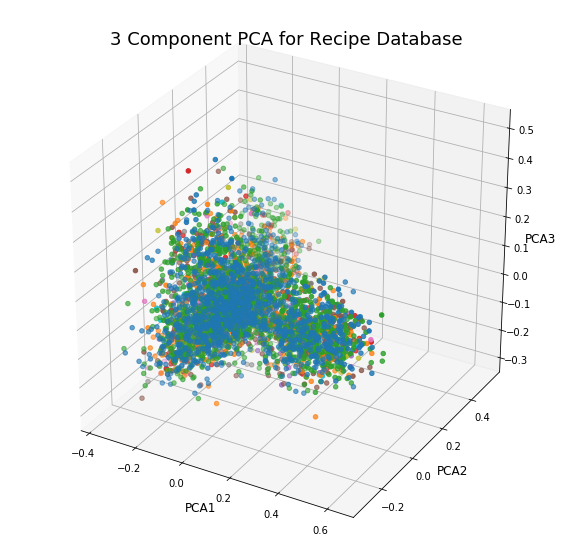

In [26]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("PCA1", fontsize=12)
ax.set_ylabel("PCA2", fontsize=12)
ax.set_zlabel("PCA3", fontsize=12)
ax.set_title('3 Component PCA for Recipe Database', fontsize=18)

targets = list(set(prepped['imputed_label']))
cmap = 'RdYlBu'
for target in targets:
    indices_to_keep = finalDF['imputed_label'] == target
    ax.scatter(xs=finalDF.loc[indices_to_keep, 'PCA1'],
               ys=finalDF.loc[indices_to_keep, 'PCA2'], 
               zs=finalDF.loc[indices_to_keep, 'PCA3'], 
               cmap = plt.cm.RdYlBu);


# Implement Logistic Regression Classifier

In [28]:
log = LogisticRegression()

In [29]:
X = ingred_word_matrix
y = prepped['imputed_label']

In [30]:
log.fit(X, y)

//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
y_predict = log.predict(X)

In [38]:
score = log.score(X, y)
print(score)

0.6503187101612299


In [70]:
cm = confusion_matrix(y, y_predict, labels=cuisines)
print(cm)

[[ 109    0    5    0    0    1    0    0    0    0    0    8   35    0
     0    2    0    0    0    0   85    0   17    2]
 [   1  499    5    1    0    1    0    0    0    0    0    0    7    0
     0    5    0    0    0    0  201    0    6    0]
 [   0    4  956    0    0    0    0    0    0    0    0   16    2    0
     0    2    0    0    0    0  142    0    7    0]
 [   0    7    5   52    0    1    0    0    0    0    0    2    7    0
     0    1    0    0    0    0  103    0    2    0]
 [   0    1   78    0   11    0    0    0    0    0    0    6    0    0
     0    0    0    0    0    0   13    0    1    0]
 [   3    4    1    0    0  144    0    0    0    1    0    2    4    0
     0   13    0    0    0    0  140    0    7    0]
 [   0    1    0    0    0    1   17    0    0    0    0    1    2    0
     0   14    0    0    0    0  115    0    5    0]
 [   0    0    0    0    0    0    0    1    0    0    3    0    0    0
     0    3    0    0    0    0  103    0    0    0]


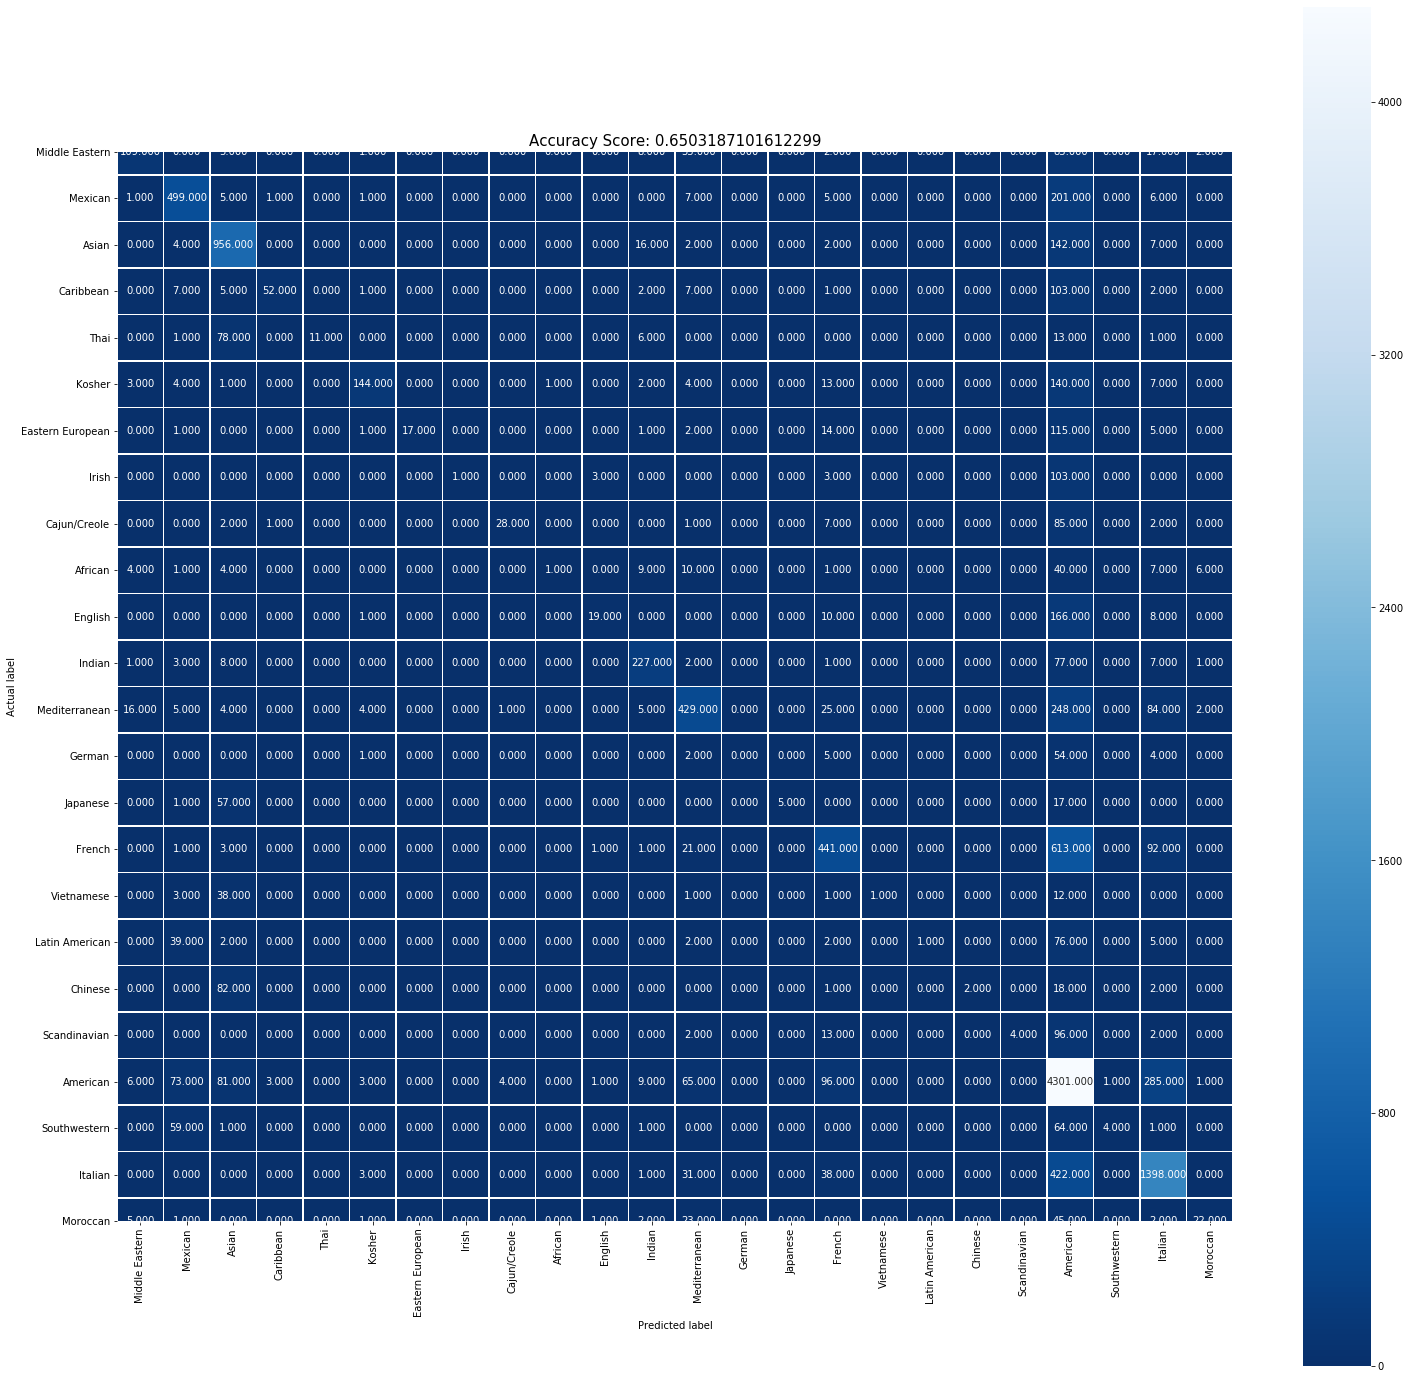

In [93]:
plt.figure(figsize=(25,25))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r',
           xticklabels=cuisines, yticklabels=cuisines);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Accuracy Score: {score}'
plt.title(all_sample_title, size = 15);

In [61]:
idx = 0
misclass_idx = []
act_and_pred = []
for label, predict in zip(y, y_predict):
    if label != predict:
        misclass_idx.append(idx)
        act_and_pred.append((idx, label, predict))
    idx += 1

In [53]:
y

16343    Mediterranean
11650          Italian
21621         American
9853          American
23180         American
             ...      
24420          English
2102           Italian
31210           German
17904         American
10201         American
Name: imputed_label, Length: 13335, dtype: object

In [56]:
y_predict

array(['Italian', 'Italian', 'American', ..., 'American', 'American',
       'Asian'], dtype=object)

In [50]:
len(misclass_idx)

4663

In [74]:
y[y=="Middle Eastern"]

31764    Middle Eastern
16989    Middle Eastern
27755    Middle Eastern
19974    Middle Eastern
18914    Middle Eastern
              ...      
28563    Middle Eastern
2015     Middle Eastern
3550     Middle Eastern
16433    Middle Eastern
6302     Middle Eastern
Name: imputed_label, Length: 264, dtype: object

In [76]:
y_predict

array(['Italian', 'Italian', 'American', ..., 'American', 'American',
       'Asian'], dtype=object)

In [87]:
combined = {'actual': y.values, 'predict': y_predict}

{'actual': array(['Mediterranean', 'Italian', 'American', ..., 'German', 'American',
        'American'], dtype=object),
 'predict': array(['Italian', 'Italian', 'American', ..., 'American', 'American',
        'Asian'], dtype=object)}

In [89]:
fp_tp_ME = pd.DataFrame(data=combined)

In [90]:
fp_tp_ME

,actual,predict
0,Mediterranean,Italian
1,Italian,Italian
2,American,American
3,American,American
4,American,American
...,...,...
13330,English,American
13331,Italian,Italian
13332,German,American
13333,American,American


In [95]:
fp_tp_ME[(fp_tp_ME['actual'] == 'Indian') & (fp_tp_ME['actual'] != fp_tp_ME['predict'])]

,actual,predict
15,Indian,American
28,Indian,American
473,Indian,Italian
622,Indian,American
1091,Indian,American
...,...,...
12595,Indian,American
12692,Indian,American
12726,Indian,American
12785,Indian,American


In [96]:
fp_tp_ME[(fp_tp_ME['actual'] == 'Indian') & (fp_tp_ME['actual'] != fp_tp_ME['predict'])]['predict'].value_counts()

American          77
Asian              8
Italian            7
Mexican            3
Mediterranean      2
Middle Eastern     1
French             1
Moroccan           1
Name: predict, dtype: int64

In [62]:
act_and_pred

[(0, 'Mediterranean', 'Italian'),
 (7, 'American', 'Mediterranean'),
 (8, 'Italian', 'American'),
 (9, 'Irish', 'American'),
 (10, 'Chinese', 'Asian'),
 (12, 'American', 'Italian'),
 (15, 'Indian', 'American'),
 (16, 'Middle Eastern', 'American'),
 (18, 'Mediterranean', 'American'),
 (22, 'Mexican', 'American'),
 (26, 'Mexican', 'American'),
 (28, 'Indian', 'American'),
 (30, 'African', 'Middle Eastern'),
 (32, 'English', 'American'),
 (34, 'French', 'American'),
 (36, 'Mexican', 'American'),
 (37, 'Asian', 'American'),
 (39, 'Mediterranean', 'American'),
 (43, 'Southwestern', 'Mexican'),
 (44, 'Cajun/Creole', 'French'),
 (45, 'Latin American', 'Italian'),
 (46, 'Moroccan', 'American'),
 (47, 'French', 'American'),
 (48, 'French', 'American'),
 (49, 'English', 'American'),
 (51, 'Kosher', 'American'),
 (52, 'Mediterranean', 'American'),
 (53, 'Vietnamese', 'Asian'),
 (54, 'Italian', 'American'),
 (56, 'Eastern European', 'American'),
 (57, 'English', 'American'),
 (59, 'Eastern Europea

# Try to find the proper amount of regularization

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [99]:
losses = []
train_losses = []
for i in np.linspace(0.0001, 10, 100):
    log = LogisticRegression(C=i)
    log.fit(X_train, y_train)
    preds = log.predict_proba(X_test)
    train_preds = log.predict_proba(X_train)
    losses.append(log_loss(y_test, preds))
    train_losses.append(log_loss(y_train, train_preds))

//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/

//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/

//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/

//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/

//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/

//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/

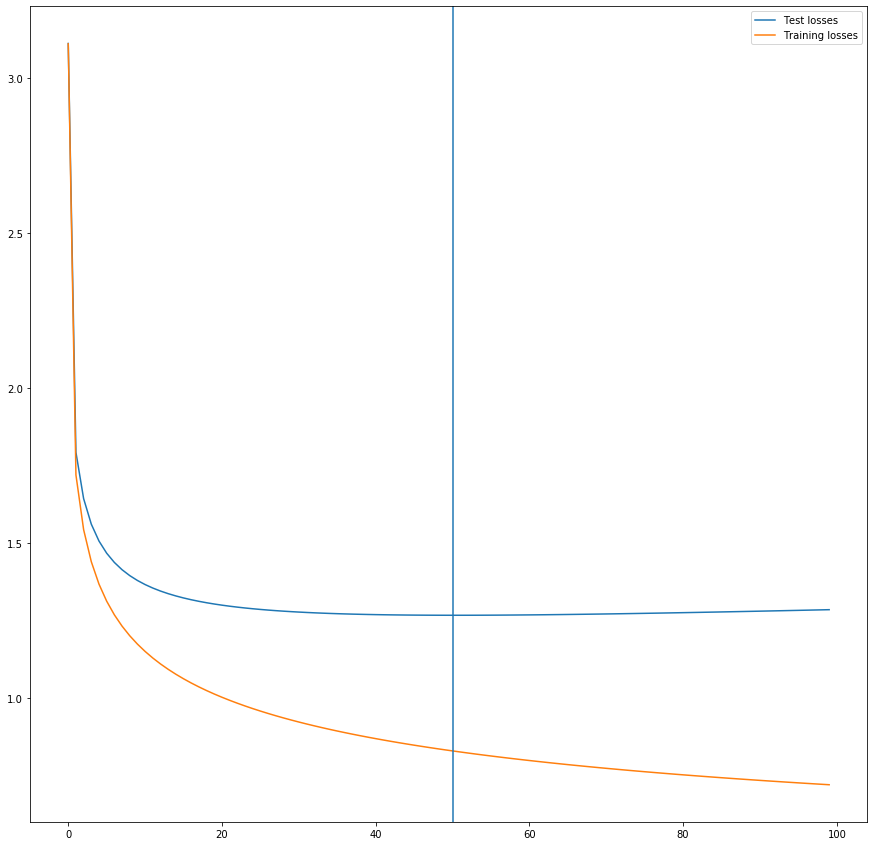

In [102]:
fig, ax = plt.subplots(figsize=(15,15))
ax.plot(losses, label='Test losses')
ax.plot(train_losses, label='Training losses')
ax.axvline(np.argmin(losses))
ax.legend()
plt.show();

In [103]:
np.argmin(losses)

50

# 

In [120]:
def find_regularization_str(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    losses = []
    train_losses = []
    cs = range(1, 10)
    for c in cs:
        log = LogisticRegression(C=c)
        log.fit(X_train, y_train)
        preds = log.predict_proba(X_test)
        train_preds = log.predict_proba(X_train)
        losses.append(log_loss(y_test, preds))
        train_losses.append(log_loss(y_train, train_preds))
        
    return cs[np.argmin(losses)]

In [121]:
find_regularization_str(X,y)

//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/

5

# Likely too much regularization, so using C=5

In [125]:
log_weakened_regularization = LogisticRegression(C=5)

In [105]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y)

In [128]:
log_weakened_regularization.fit(X_train2, y_train2)
y_predict = log_weakened_regularization.predict(X_test2)
# cm = confusion_matrix(y_test2, y_predict, labels=cuisines)
print(classification_report(y_test2, y_predict, labels=cuisines))
# plt.figure(figsize=(25,25))
# sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'PuOr',
#            xticklabels=cuisines, yticklabels=cuisines);
# plt.ylabel('Actual label');
# plt.xlabel('Predicted label');
# plt.title(all_sample_title, size = 15);

//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


                  precision    recall  f1-score   support

  Middle Eastern       0.60      0.44      0.51        55
         Mexican       0.64      0.66      0.65       147
           Asian       0.70      0.78      0.74       287
       Caribbean       0.76      0.45      0.57        42
            Thai       0.29      0.05      0.09        37
          Kosher       0.83      0.45      0.58        87
Eastern European       0.73      0.22      0.33        37
           Irish       0.50      0.07      0.12        29
    Cajun/Creole       0.56      0.27      0.37        33
         African       0.00      0.00      0.00        19
         English       0.44      0.07      0.12        55
          Indian       0.73      0.66      0.70        86
   Mediterranean       0.56      0.49      0.53       197
          German       0.50      0.10      0.17        20
        Japanese       0.40      0.10      0.15        21
          French       0.47      0.40      0.43       287
      Vietnam

### Precision: TP / (TP + FP) (How many selected items are relevant), Recall: TP / (TP + FN) (how many relevant items are selected), Support is number of examples
Here, the classifier never guessed African or Southwestern

# SMOTE data

In [ ]:
sm = SMOTE(random_state=42)

In [ ]:
X_res, y_res = sm.fit_resample(combo.drop(['imputed_label'], axis=1), training_labels)

# Initialize arguments for Neural Net

In [ ]:
to_nn = combo.drop(['imputed_label'], axis=1)

In [ ]:
embedding_size = 100
epochs_desired = 20
learning_rate = 0.025
regularization = 0.01
vocabulary_size = len(tfidf.get_feature_names())
algo_optimizer = 'adam'

In [ ]:
model = keras.Sequential([
                        keras.layers.Embedding(input_dim=vocabulary_size, 
                                               output_dim=embedding_size,
                                               embeddings_initializer='normal'
                                              ),
                        keras.layers.GlobalMaxPooling1D(),
                        keras.layers.Dense(200, activation='relu'),
                        keras.layers.Dropout(0.2),
                        keras.layers.Dense(150, activation='relu'),
                        keras.layers.Dropout(0.2),
                        keras.layers.Dense(100, activation='relu'),
                        keras.layers.Dropout(0.2),
                        keras.layers.Dense(len(lab_enc.classes_), activation='softmax')
                      ])

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate, 
                                                  beta_1=0.9, 
                                                  beta_2=0.999, 
                                                  epsilon=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [ ]:
model.fit(X_res, y_res, epochs=epochs_desired)

# Use reduced dimensionality (50)

In [ ]:
tsvd1 = TruncatedSVD(n_components=50, random_state=20)

In [ ]:
tsvd1.fit(to_nn)

In [ ]:
tsvd1_ingreds = tsvd1.transform(to_nn)
tsvd1_ingreds.shape

In [ ]:
X_res2, y_res2 = sm.fit_resample(tsvd1_ingreds, training_labels)

In [ ]:
model2 = keras.Sequential([
                        keras.layers.Embedding(input_dim=tsvd1_ingreds.shape[1], 
                                               output_dim=30,
                                               embeddings_initializer='normal'
                                              ),
                        keras.layers.GlobalMaxPooling1D(),
                        keras.layers.Dense(60, activation='relu'),
                        keras.layers.Dropout(0.2),
                        keras.layers.Dense(len(lab_enc.classes_), activation='softmax')
                      ])

In [ ]:
model2.compile(optimizer=keras.optimizers.Adam(learning_rate, 
                                                  beta_1=0.9, 
                                                  beta_2=0.999, 
                                                  epsilon=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [ ]:
model2.fit(X_res2, y_res2, epochs=epochs_desired)

# Create target labels

In [ ]:
lab_enc = LabelBinarizer()

In [ ]:
training_labels = lab_enc.fit_transform(combo['imputed_label'])

In [ ]:
lab_enc.classes_

In [ ]:
len(lab_enc.classes_)

In [ ]:
label_index = [np.argmax(label) for label in training_labels]
label_index

In [ ]:
len(label_index)

# Reduce dimensionality (30)

In [ ]:
tsvd2 = TruncatedSVD(n_components=30, random_state=20)

In [ ]:
tsvd2.fit(combo.drop(['imputed_label'], axis=1))
tsvd2_ingreds = tsvd2.transform(combo.drop(['imputed_label'], axis=1))

In [ ]:
tsvd2_ingreds.shape[1]

In [ ]:
model3 = keras.Sequential([
                        keras.layers.Embedding(input_dim=tsvd2_ingreds.shape[1], 
                                               output_dim=tsvd2_ingreds.shape[1],
                                               embeddings_initializer='normal'
                                              ),
                        keras.layers.GlobalMaxPooling1D(),
                        keras.layers.Dense(60, activation='relu'),
                        keras.layers.Dense(60, activation='relu'),
                        keras.layers.Dense(60, activation='relu'),
                        keras.layers.Dense(60, activation='relu'),
                        keras.layers.Dense(len(lab_enc.classes_), activation='softmax')
                      ])

In [ ]:
model3.compile(optimizer=keras.optimizers.Adam(learning_rate, 
                                                  beta_1=0.9, 
                                                  beta_2=0.999, 
                                                  epsilon=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [ ]:
X_res2a, y_res2a = sm.fit_resample(tsvd2_ingreds, training_labels)

In [ ]:
model3.fit(X_res2a, y_res2a, epochs=epochs_desired, shuffle=True)

In [ ]:
lab_enc.classes_[2]

In [ ]:
smoted_labels = [lab_enc.classes_[np.argmax(recipe)] for recipe in y_res2a]

In [ ]:
test3=model3.predict(X_res2a)

In [ ]:
test3.shape

In [ ]:
[test3[0] == row for row in test3]

In [ ]:
np.argmax(test3)

# Try Decision Tree instead of Neural Net

In [ ]:
dtc = DecisionTreeClassifier(max_depth=30,random_state=20)

In [ ]:
X_res4, y_res4 = sm.fit_resample(combo.drop(['imputed_label'], axis=1), combo['imputed_label'])   

In [ ]:
dtc = dtc.fit(X_res4, y_res4)

In [ ]:
y_res4_pred = dtc.predict(X_res4)

In [ ]:
print("Accuracy:",sklearn.metrics.accuracy_score(y_res4, y_res4_pred))

In [ ]:
print(sklearn.metrics.confusion_matrix(y_res4, y_res4_pred))

In [ ]:
print(sklearn.metrics.classification_report(y_res4, y_res4_pred))

In [ ]:
test_labeled_cuisine_df['imputed_label']

In [ ]:
test_nlpskl

In [ ]:
test_pred = dtc.predict(test_nlpskl)

In [ ]:
print("Accuracy:",sklearn.metrics.accuracy_score(test_labeled_cuisine_df['imputed_label'], 
                                                 test_pred))
print(sklearn.metrics.confusion_matrix(test_labeled_cuisine_df['imputed_label'], 
                                                 test_pred))
print(sklearn.metrics.classification_report(test_labeled_cuisine_df['imputed_label'], 
                                                 test_pred))

---

In [ ]:
dtc2 = DecisionTreeClassifier(max_depth=200,random_state=20)
X_res5 = combo.drop(['imputed_label'], axis=1)
y_res5 = combo['imputed_label']
dtc2 = dtc2.fit(X_res5, y_res5)
y_res5_pred = dtc.predict(X_res5)
print("Accuracy:",sklearn.metrics.accuracy_score(y_res5, y_res5_pred))
print(sklearn.metrics.confusion_matrix(y_res5, y_res5_pred))
print(sklearn.metrics.classification_report(y_res5, y_res5_pred))

In [ ]:
test_pred2 = dtc2.predict(test_nlpskl)
print("Accuracy:",sklearn.metrics.accuracy_score(test_labeled_cuisine_df['imputed_label'], 
                                                 test_pred2))
print(sklearn.metrics.confusion_matrix(test_labeled_cuisine_df['imputed_label'], 
                                                 test_pred2))
print(sklearn.metrics.classification_report(test_labeled_cuisine_df['imputed_label'], 
                                                 test_pred2))